In [0]:
%tensorflow_version 2.x
import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose

import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import argparse
import os


TensorFlow 2.x selected.


In [0]:
######################
### Load/Check TPU ###
######################

print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('Error: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.1.0
Running on TPU  ['10.60.94.234:8470']
INFO:tensorflow:Initializing the TPU system: 10.60.94.234:8470


INFO:tensorflow:Initializing the TPU system: 10.60.94.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
#############################
### Sampling and Plotting ###
#############################


# reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):   #args (tensor): mean and log of variance of Q(z|X)
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon  # Returns ampled latent vector


#plots latent space and samples
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_eeg"):
    #plot each row for a eeg signle

    encoder, decoder = models
    x_test, y_test = data
    print(x_test.shape)
    print(y_test.shape)
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")

    z_sample = np.array([[22,1000]])
    x_decoded = decoder.predict(z_sample)
    print(x_decoded.shape)
    fs = 250
    increments = np.linspace(0,1000,1000)
    
    plt.figure()

    for i in range(0, 22):
      y = np.row_stack((x_decoded[:,i,:,:]))

      #print(y)
      plt.plot(increments, (y), '.')
      plt.xlabel("Sample Index [n]")
      plt.ylabel("z[n]")
      plt.title("Single Trial, all EEG")




#plot_results(models, data, batch_size=batch_size, model_name="vae_eed")


In [0]:
###################
### mount drive ###
###################

from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##########################
### Preprocessing Data ###
##########################

import os
import numpy as np
import random
from importlib import reload
try:  
  project_fname = '/content/drive/My Drive/c247/'
  os.chdir(project_fname)
  project_data_file = os.path.join(project_fname,'project_data/')
except FileNotFoundError: 
  project_fname = '/content/drive/My Drive/Colab Notebooks/c247/'
  os.chdir(project_fname)
  project_data_file = os.path.join(project_fname,'project_data/')


%cd /content/drive/My Drive/c247/
from load_data import *
from data_preprocessing import * 

X_test, y_test, person_train_valid, X_train_valid, y_train_valid, person_test = load_data(dir_path = project_data_file)   #load data

#normalize data
N_trials,N_eeg,N_bins,_ = X_train_valid.shape
X_train_valid_norm = np.reshape(preprocessing.scale(np.reshape(X_train_valid,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))
N_trials,N_eeg,N_bins,_ = X_test.shape
X_test_norm = np.reshape(preprocessing.scale(np.reshape(X_test,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))

# print data
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

/content
Training/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
######################
### Network Params ###
######################

#function is unessary, but was made for upscaling. Process was halted due to "mode collapse"
def NetworkParameters (image_size,batch_size,kernel_size, filters, latent_dim, epochs):
  # network parameters
  input_shape = (image_size[0], image_size[1],1)
  image_size = input_shape
  batch_size = batch_size
  kernel_size = kernel_size
  filters = filters
  latent_dim = latent_dim
  epochs = epochs
  return input_shape,image_size,batch_size,kernel_size, filters, latent_dim, epochs

(input_shape, 
 image_size,
 batch_size, 
 kernel_size, 
 filters, 
 latent_dim, 
 epochs) = NetworkParameters(image_size = X_train_valid.shape[1:3],
                                                    batch_size = 128,
                                                    kernel_size = 7,
                                                    filters = 16,
                                                    latent_dim = 2,
                                                    epochs = 30)
 

In [0]:
#####################
### CNN VAE Model ###
#####################
#VAE model = encoder + decoder

#encoder model
inputs = Input(shape=input_shape, name='encoder_input')
print(inputs)
x = inputs
filters *= 2

#Temporal conv
x = Conv2D(filters=filters,
          kernel_size=(1, 50),
          strides=(1,25),
          )(x)
#x = BatchNormalization(epsilon=1e-5)(x) #Not normally used
x = LeakyReLU(alpha=0.3)(x)


filters *= 2
#Spatial Conv
x = Conv2D(filters=filters,
          kernel_size=(22, 1),
          )(x)
#x = BatchNormalization(epsilon=1e-5)(x) #Not normally used
x = LeakyReLU(alpha=0.3)(x)

#shape info needed to build decoder model
shape = K.int_shape(x)

#latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = z_log_var + 1e-8 
print("zlog ", z_log_var)

#reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,I)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) #sample output as input

#compile encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

#decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

#reverse: spatial conv
x = Conv2DTranspose(filters=filters,
              kernel_size=(22, 1),
              activation='relu',
              )(x)
#x = BatchNormalization(epsilon=1e-5)(x)

filters //= 2

#reverse: temporal conv
x = Conv2DTranspose(filters=filters,
          kernel_size=(1, 50),
          activation='relu',
          strides=(1,25))(x)
#x = BatchNormalization(epsilon=1e-5)(x)

filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          name='decoder_output')(x)

#compile decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

#compile VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Tensor("encoder_input:0", shape=(None, 22, 1000, 1), dtype=float32)
zlog  Tensor("add:0", shape=(None, 2), dtype=float32)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 22, 1000, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 39, 32)   1632        encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 22, 39, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 39, 64)    45120       leak

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 22, 1000, 1) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 86772       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 22, 1000, 1)  201665      encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 39, 32)   1632        encoder_input[0][0]              
________________________________________________________________________________________________

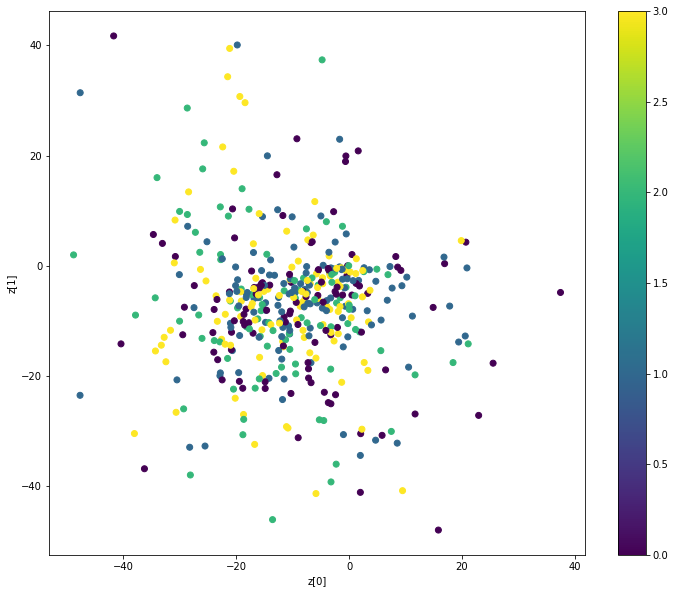

(1, 22, 1000, 1)


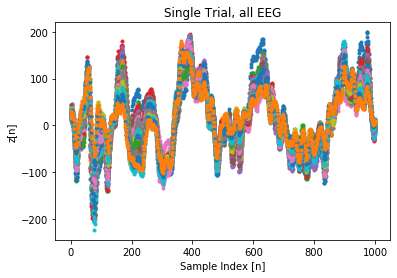

In [0]:
######################################
### Optimize CNN VAE Loss Function ###
######################################

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m", "--mse", help=help_, action='store_true')
    args = parser.parse_args(args = [])
    models = (encoder, decoder)
    data = (X_test, y_test)


    
    #VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    else:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        #reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  #K.flatten(outputs))

    reconstruction_loss *= image_size[0] * image_size[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    optimizer = Adam(learning_rate=0.001, beta_1=0.1, beta_2=0.999, amsgrad=False)

    vae.compile(optimizer=optimizer, loss=None)

    vae.summary()
    plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

    if args.weights:
        #Load
        vae.load_weights(args.weights)
    else:
        #Train
        history = vae.fit(x = X_train_valid,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_test, None))
    #plot
    plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

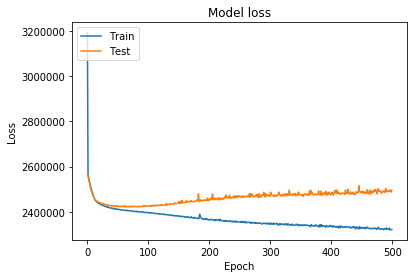

In [0]:
#########################################
### CNN VAE Model Loss for 500 epochs ###
#########################################


#Plot training & validation loss values
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("Model_Loss.png")

plt.show()

